In [140]:
!git config --global user.name "Belaleatsbanana"
!git config --global user.email "belalofficial123@gmail.com"

In [ ]:
# Clone the repository
!git clone https://github.com/Belaleatsbanana/ml2.git
%cd ml2

In [142]:
%pip install -r requirements.txt

# Dataset Description: Dou Shou Qi (Jungle Chess)

## Game Overview
**Dou Shou Qi** ("Game of Fighting Animals") is a Chinese board game also known as:
- Jungle Chess


## Game Characteristics
- **Type**: Two-player abstract strategy game
- **Origins**: Evolved around the 1900s in China
- **Similar to**: Chess, Stratego, and other Chinese Chess-like games (e.g., Banqi)
- **First described by**: Pritchard and Beasley (2007)

## Board Layout
- **Dimensions**: 9 × 7 rectangular board (63 squares)
- **Files (columns)**: Labeled a–g (left to right)
- **Ranks (rows)**: Numbered 1–9 (bottom to top, from white player's perspective)

## Game Pieces
Each player has 8 pieces representing animals with different strengths:
- **Strength 7**: Elephant (strongest)
- **Strength 6**: Lion
- **Strength 5**: Tiger
- **Strength 4**: Leopard
- **Strength 3**: Wolf (Dog)
- **Strength 2**: Cat
- **Strength 1**: Rat (Mouse)
- **Strength 0**: Den (goal position)

## Special Board Features
- **Dens**: Each player's home square (must be defended)
- **Traps**: Squares that weaken pieces
- **Water/Rivers**: Special squares that only Rats can enter

## Dataset Purpose
This dataset contains game states from Dou Shou Qi matches, where:
- **Features**: Board positions, piece locations, distances to dens, tactical positions
- **Target**: Game outcome (winner: 'w' for white, 'b' for black)
- **Application**: Predict game outcomes from board states for strategic analysis

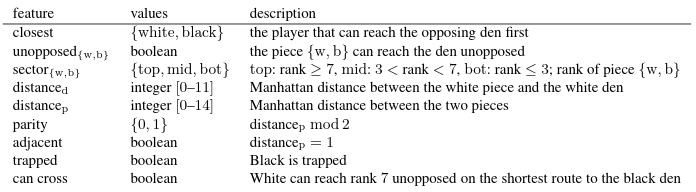


---

## Statistical Insights from Dataset (5,880 game states)

### Piece Distribution
- **Strength Balance**: Both white and black pieces have identical mean strength of 3.5, indicating perfectly balanced dataset
- **Strength Range**: Pieces range from 0 (Den) to 7 (Elephant), with equal distribution across all strength levels
- **Position Spread**: Files average 3.0 (center of a-g board) and ranks average 4.0 (middle of 9 rows), showing pieces are well-distributed across the board

### Distance Metrics
- **Den Distances**: Both white and black pieces average ~5.8 moves to either den (min: 1, max: 11)
- **Tactical Positioning**: The median distance to dens is 6 moves, suggesting most game states are in mid-game phase
- **Distance Symmetry**: `closest_to_den_diff` averages 3.25, showing significant positional advantages vary throughout games

### Special Board Features Usage
- **Trap Occupancy**: Only ~5.5% of pieces are in trap squares (rare but strategic)
- **Water Presence**: 10% of pieces are in water (only Rats can occupy these squares)
- **River Crossing Ability**: 
  - White pieces can cross in 75% of states
  - Black pieces can cross in 67% of states
  - Indicates white has slightly better mobility on average

### Tactical Indicators
- **Unopposed to Den**: 
  - White: 56.9% of states have unopposed path to black's den
  - Black: 47.3% of states have unopposed path to white's den
  - **Key Insight**: White appears to have tactical advantage in ~10% more game states

- **Quick Detour Opportunities**:
  - White: 38% can make quick detour to den
  - Black: 27.9% can make quick detour to den
  - Shows white's superior tactical flexibility

- **Bank Control**: 
  - White: 94.6% have unopposed path to river bank
  - Black: 88.4% have unopposed path to river bank
  - White demonstrates better board control

### Position-Specific Features
- **Black at d7**: Only 1.8% of states have black piece at this critical position (likely a defensive/strategic square)
- **Unopposed Path Variability**: 
  - `unopposedto_black_den_length` has high std (2.78), showing paths vary greatly
  - Value of -1 indicates blocked paths (common at 25th percentile)

In [ ]:
# imports
# Data manipulation and exploration
import numpy as np
import pandas as pd
from scipy import stats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
cmap = "rocket"
colors = ['#3498db', '#e74c3c', '#95a5a6']

# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

# Handling imbalanced data
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Pipelines
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score, matthews_corrcoef,
    cohen_kappa_score, log_loss, balanced_accuracy_score, make_scorer
)

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature


RANDOM_SEED = int("GOGU", 36)

# Helper function to display .info() as a DataFrame
def info_df(df):
    """Display DataFrame.info() as a DataFrame for better visualization"""
    info_dict = {
        'Column': df.columns,
        'Non-Null Count': [df[col].count() for col in df.columns],
        'Null Count': [df[col].isna().sum() for col in df.columns],
        'Dtype': [df[col].dtype for col in df.columns],
        'Unique': [df[col].nunique() for col in df.columns]
    }
    info_table = pd.DataFrame(info_dict)
    print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    return info_table


In [144]:
# Load dataset and handle missing values
jungle_dataset = pd.read_csv('bell/rat_elephant_data.csv', na_values=['\\N'])

print(f"Dataset Shape: {jungle_dataset.shape}")
jungle_dataset.head(5)

Dataset Shape: (5880, 47)


,white_piece0_strength,white_piece0_file,white_piece0_rank,white_piece0_advanced,white_piece0_distanceto_white_den,white_piece0_distanceto_black_den,white_piece0_unopposedto_black_den_length,white_piece0_unopposedto_black_den_shortest,white_piece0_movesto_white_den,white_piece0_movesto_black_den,white_piece0_in_trap,white_piece0_in_water,white_piece0_can_cross,white_piece0_can_cross_shortest,white_piece0_unopposed_to_bank,white_piece0_distanceto_black_piece0,white_piece0_distanceto_black_piece0_parity,white_piece0_nextto_black_piece0,black_piece0_strength,black_piece0_file,black_piece0_rank,black_piece0_advanced,black_piece0_distanceto_white_den,black_piece0_distanceto_black_den,black_piece0_movesto_white_den,black_piece0_movesto_black_den,black_piece0_unopposedto_white_den_length,black_piece0_unopposedto_white_den_shortest,black_piece0_in_trap,black_piece0_in_water,black_piece0_can_cross,black_piece0_can_cross_shortest,black_piece0_unopposed_to_bank,black_piece0_at_d7,black_piece0_distanceto_white_piece0,black_piece0_distanceto_white_piece0_parity,black_piece0_nextto_white_piece0,highest_strength,closest_to_den,closest_to_den_diff,fastest_to_den,fastest_to_den_diff,white_unopposed_to_den,black_unopposed_to_den,white_unopposed_to_den_quick_detour,black_unopposed_to_den_quick_detour,class
0,7,0,0,DEF,3,11,-1,0,3,11,0,0,1,1,1,1.0,1.0,1.0,0,1,0,ATT,2,10,2,10,-1,0,0,0,1,1,0,0,1.0,1.0,1.0,w,b,9,b,9,0,0,0,0,w
1,7,0,0,DEF,3,11,-1,0,3,11,0,0,1,1,1,2.0,0.0,0.0,0,2,0,ATT,1,9,1,9,0,0,1,0,1,1,1,0,2.0,0.0,0.0,w,b,10,b,10,0,1,0,1,b
2,7,0,0,DEF,3,11,-1,0,3,11,0,0,1,1,1,6.0,0.0,0.0,0,4,0,ATT,1,9,1,9,0,0,1,0,1,1,1,0,6.0,0.0,0.0,w,b,10,b,10,0,1,0,1,b
3,7,0,0,DEF,3,11,10,0,3,11,0,0,1,1,1,7.0,1.0,0.0,0,5,0,ATT,2,10,2,10,1,0,0,0,1,1,1,0,7.0,1.0,0.0,w,b,9,b,9,1,1,0,1,b
4,7,0,0,DEF,3,11,10,0,3,11,0,0,1,1,1,8.0,0.0,0.0,0,6,0,ATT,3,11,3,11,2,0,0,0,1,1,1,0,8.0,0.0,0.0,w,b,8,b,8,1,1,0,1,b


In [145]:
# Perform stratified train-test split

X = jungle_dataset.drop('class', axis=1)
y = jungle_dataset['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_SEED
)

train_data = X_train.copy()
train_data['class'] = y_train

test_data = X_test.copy()
test_data['class'] = y_test

print("\nOriginal:")
print(jungle_dataset['class'].value_counts(normalize=True).sort_index())

print("\nTraining:")
print(train_data['class'].value_counts(normalize=True).sort_index())

print("\nTest:")
print(test_data['class'].value_counts(normalize=True).sort_index())


Original:
class
b    0.372619
d    0.131293
w    0.496088
Name: proportion, dtype: float64

Training:
class
b    0.372662
d    0.131378
w    0.495961
Name: proportion, dtype: float64

Test:
class
b    0.372449
d    0.130952
w    0.496599
Name: proportion, dtype: float64


In [146]:
# datasets info
info_df(train_data)

Dataset Shape: 4704 rows × 47 columns


,Column,Non-Null Count,Null Count,Dtype,Unique
0,white_piece0_strength,4704,0,int64,2
1,white_piece0_file,4704,0,int64,7
2,white_piece0_rank,4704,0,int64,9
3,white_piece0_advanced,4704,0,object,3
4,white_piece0_distanceto_white_den,4704,0,int64,11
5,white_piece0_distanceto_black_den,4704,0,int64,11
6,white_piece0_unopposedto_black_den_length,4704,0,int64,12
7,white_piece0_unopposedto_black_den_shortest,4704,0,int64,1
8,white_piece0_movesto_white_den,4704,0,int64,11
9,white_piece0_movesto_black_den,4704,0,int64,11


In [147]:
# datasets desc
# Looks insanly better
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
white_piece0_strength,4704.0,3.501488,3.500372,0.0,0.0,7.0,7.0,7.0
white_piece0_file,4704.0,2.988095,2.075614,0.0,1.0,3.0,5.0,6.0
white_piece0_rank,4704.0,4.004464,2.647595,0.0,2.0,4.0,6.0,8.0
white_piece0_distanceto_white_den,4704.0,5.806335,2.839553,1.0,3.0,6.0,8.0,11.0
white_piece0_distanceto_black_den,4704.0,5.797406,2.842223,1.0,3.0,6.0,8.0,11.0
white_piece0_unopposedto_black_den_length,4704.0,1.424532,2.774892,-1.0,-1.0,1.0,3.0,10.0
white_piece0_unopposedto_black_den_shortest,4704.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
white_piece0_movesto_white_den,4704.0,5.806335,2.839553,1.0,3.0,6.0,8.0,11.0
white_piece0_movesto_black_den,4704.0,5.797406,2.842223,1.0,3.0,6.0,8.0,11.0
white_piece0_in_trap,4704.0,0.053359,0.224772,0.0,0.0,0.0,0.0,1.0


In [148]:
# value counts
for col in train_data.columns:
    print(f"Value counts for column '{col}':")
    print(train_data[col].value_counts())
    print("\n")

Value counts for column 'white_piece0_strength':
white_piece0_strength
7    2353
0    2351
Name: count, dtype: int64


Value counts for column 'white_piece0_file':
white_piece0_file
0    772
6    759
1    660
4    653
5    640
2    630
3    590
Name: count, dtype: int64


Value counts for column 'white_piece0_rank':
white_piece0_rank
2    620
6    617
7    611
1    604
8    509
0    508
4    423
5    407
3    405
Name: count, dtype: int64


Value counts for column 'white_piece0_advanced':
white_piece0_advanced
ATT    1737
DEF    1732
MID    1235
Name: count, dtype: int64


Value counts for column 'white_piece0_distanceto_white_den':
white_piece0_distanceto_white_den
3     597
8     544
9     515
4     497
7     491
2     442
5     435
6     421
10    347
1     251
11    164
Name: count, dtype: int64


Value counts for column 'white_piece0_distanceto_black_den':
white_piece0_distanceto_black_den
3     596
8     527
9     525
4     516
7     512
2     449
6     417
5     406
10    342
1 

## Understanding features and their values in the Dataset

### Negative Values (-1)
The value **-1** in "unopposed" path features indicates:
- **`white_piece0_unopposedto_black_den_length = -1`**: White piece does NOT have a clear path to black's den
- **`black_piece0_unopposedto_white_den_length = -1`**: Black piece does NOT have a clear path to white's den

This is a **sentinel value** meaning:
- The path is **blocked** by an opponent's piece
- No clear route exists to the enemy den
- The piece would face opposition trying to reach the goal

When the value is **≥ 0**, it represents the **length of the unopposed path** in squares. (Manhattan Distance)

### Missing Values (\N -> NaN)




### White Piece Features (piece0 = strongest/most important piece)

#### Position Features
- **`white_piece0_strength`**: Piece power level
  - Range: 0-7 (0=Rat, 1=Cat, 2=Dog, 3=Wolf, 4=Leopard, 5=Tiger, 6=Lion, 7=Elephant)
  - Values: `[0, 1, 2, 3, 4, 5, 6, 7]`

- **`white_piece0_file`**: Column position on board
  - Range: 0-6 (represents files a-g)
  - Values: `[0, 1, 2, 3, 4, 5, 6]`

- **`white_piece0_rank`**: Row position on board
  - Range: 0-8 (represents ranks 1-9)
  - Values: `[0, 1, 2, 3, 4, 5, 6, 7, 8]`

- **`white_piece0_advanced`**: Territorial position
  - Values: `['DEF', 'MID', 'ATT']`
  - `DEF` = Defensive third (near own den)
  - `MID` = Middle third (neutral territory)
  - `ATT` = Attacking third (near enemy den)

#### Distance Metrics
- **`white_piece0_distanceto_white_den`**: Manhattan distance to own den
  - Range: 1-11 moves
  - Lower = closer to home/defense

- **`white_piece0_distanceto_black_den`**: Manhattan distance to enemy den
  - Range: 1-11 moves
  - Lower = better attacking position

- **`white_piece0_movesto_white_den`**: Actual moves needed to reach own den
  - Range: 1-11 moves
  - Considers obstacles (water, traps)

- **`white_piece0_movesto_black_den`**: Actual moves needed to reach enemy den
  - Range: 1-11 moves
  - Considers obstacles

#### Path Features
- **`white_piece0_unopposedto_black_den_length`**: Length of clear path to enemy den
  - Values: `-1` = blocked/no clear path, `0-10` = path length in squares
  - Key tactical indicator!

- **`white_piece0_unopposedto_black_den_shortest`**: Is it the shortest unopposed path?
  - Values: `0` = No, `1` = Yes (but always 0 in this dataset)

#### Board Feature Occupancy
- **`white_piece0_in_trap`**: Is piece in a trap square?
  - Values: `0` = No, `1` = Yes
  - Trap squares weaken pieces (vulnerability indicator)

- **`white_piece0_in_water`**: Is piece in water/river?
  - Values: `0` = No, `1` = Yes
  - Only Rats can be in water

#### Mobility Features
- **`white_piece0_can_cross`**: Can piece cross the river?
  - Values: `0` = No, `1` = Yes
  - Lions and Tigers can jump across, Rat can swim

- **`white_piece0_can_cross_shortest`**: Can cross via shortest path?
  - Values: `0` = No, `1` = Yes

- **`white_piece0_unopposed_to_bank`**: Clear path to river bank?
  - Values: `0` = Blocked, `1` = Clear

#### Piece-to-Piece Relationships
- **`white_piece0_distanceto_black_piece0`**: Distance to strongest black piece
  - Range: 1-14 moves (or NaN if undefined)
  - Indicates potential combat engagement

- **`white_piece0_distanceto_black_piece0_parity`**: Distance parity (even/odd)
  - Values: `0` = Even, `1` = Odd, `NaN` = undefined
  - Affects who can initiate combat

- **`white_piece0_nextto_black_piece0`**: Adjacent to enemy's strongest piece?
  - Values: `0` = No, `1` = Yes, `NaN` = undefined
  - Immediate combat threat indicator

### Black Piece Features
Mirror of white piece features with same interpretations:
- `black_piece0_strength`, `black_piece0_file`, `black_piece0_rank`
- `black_piece0_advanced` (from black's perspective)
- Distance, path, occupancy, and mobility features (analogous to white)

#### Black-Specific Feature
- **`black_piece0_at_d7`**: Is black piece at critical square d7?
  - Values: `0` = No, `1` = Yes
  - d7 is strategically important (near white's den)
  - Only 1.8% of states have this

### Game State Features

- **`highest_strength`**: Which player has the strongest piece?
  - Values: `'w'` = White, `'b'` = Black

- **`closest_to_den`**: Who is closer to enemy den?
  - Values: `'w'` = White closer, `'b'` = Black closer

- **`closest_to_den_diff`**: Distance advantage (absolute difference)
  - Range: 0-10 moves
  - Higher = larger positional advantage

- **`fastest_to_den`**: Who can reach enemy den faster?
  - Values: `'w'` = White, `'b'` = Black

- **`fastest_to_den_diff`**: Speed advantage (move difference)
  - Range: 0-10 moves

- **`white_unopposed_to_den`**: White has clear path to black's den?
  - Values: `0` = No, `1` = Yes
  - 56.9% are Yes

- **`black_unopposed_to_den`**: Black has clear path to white's den?
  - Values: `0` = No, `1` = Yes
  - 47.3% are Yes (white advantage!)

- **`white_unopposed_to_den_quick_detour`**: White can detour 1-2 moves and still reach?
  - Values: `0` = No, `1` = Yes
  - 38% are Yes

- **`black_unopposed_to_den_quick_detour`**: Black can make quick detour?
  - Values: `0` = No, `1` = Yes
  - 27.9% are Yes

### Target Variable

- **`class`**: Game winner
  - Values: `'w'` = White wins, `'b'` = Black wins, `'d'` = Draw
  - **Primary prediction target**


---
# Phase 1: Light EDA - Discovering Data Issues

Before cleaning, we need to understand what issues exist in the data. This light EDA will identify:
1. Missing values patterns
2. Data type inconsistencies
3. Outliers and anomalies
4. Class imbalance
5. Feature distributions


In [149]:
# 1. Missing Values Analysis
missing_stats = pd.DataFrame({
    'Missing_Count': train_data.isna().sum(),
    'Missing_Percentage': (train_data.isna().sum() / len(train_data)) * 100,
    'Dtype': train_data.dtypes
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
missing_stats

,Missing_Count,Missing_Percentage,Dtype
white_piece0_distanceto_black_piece0,474,10.076531,float64
white_piece0_distanceto_black_piece0_parity,474,10.076531,float64
white_piece0_nextto_black_piece0,474,10.076531,float64
black_piece0_distanceto_white_piece0,469,9.970238,float64
black_piece0_distanceto_white_piece0_parity,469,9.970238,float64
black_piece0_nextto_white_piece0,469,9.970238,float64


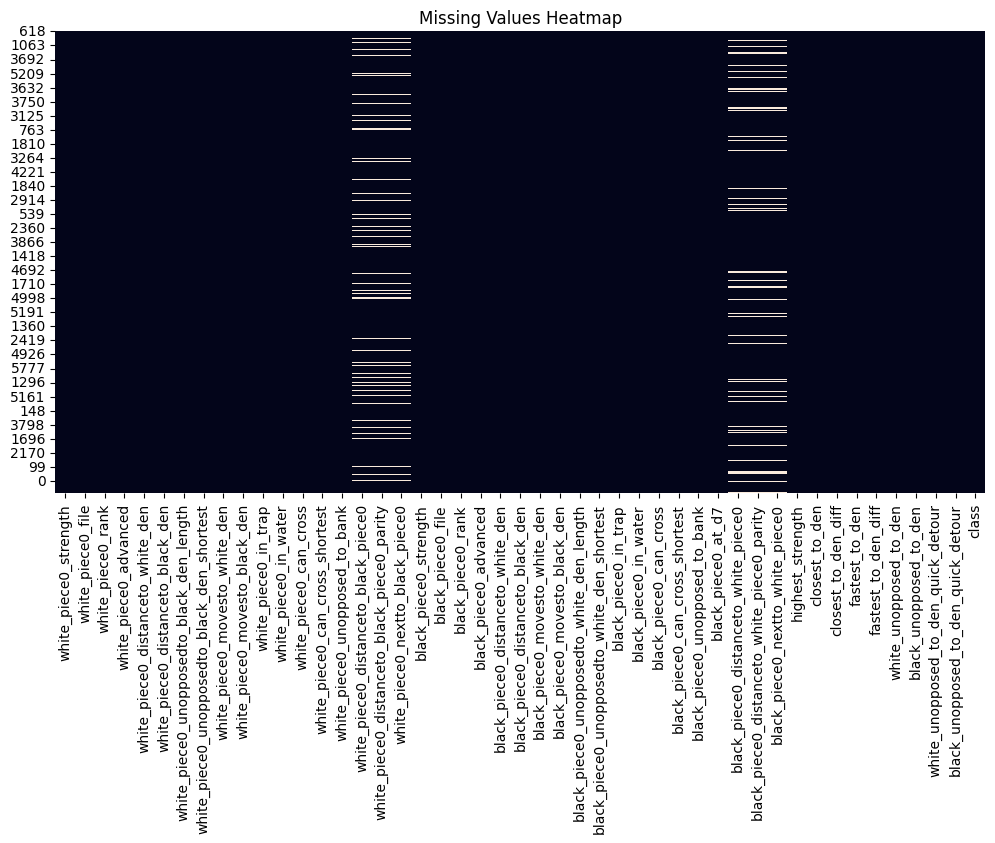

In [150]:
# Heatmap of missing values
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.isna(), cbar=False, cmap=cmap)
plt.title('Missing Values Heatmap')
plt.show()

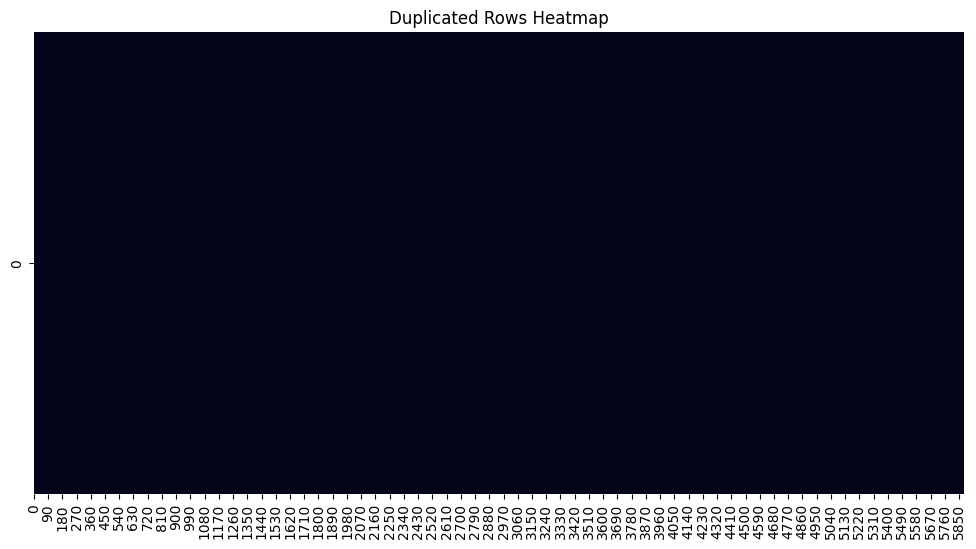

In [151]:
# Heatmap of duplicated rows
plt.figure(figsize=(12, 6))
sns.heatmap(jungle_dataset.duplicated().to_frame().T, cbar=False, cmap=cmap)
plt.title('Duplicated Rows Heatmap')
plt.show()

In [152]:
# 2. Target Variable Analysis (Class Balance)
class_counts = train_data['class'].value_counts()
class_pct = train_data['class'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
for cls in class_counts.index:
    print(f"\t{cls}: {class_counts[cls]:,} ({class_pct[cls]:.2f}%)")

# Check for imbalance
max_class_pct = class_pct.max()
min_class_pct = class_pct.min()
imbalance_ratio = max_class_pct / min_class_pct
print(f"\nThe class imbalance ratio is {imbalance_ratio:.2f}")


Class Distribution:
	w: 2,333 (49.60%)
	b: 1,753 (37.27%)
	d: 618 (13.14%)

The class imbalance ratio is 3.78


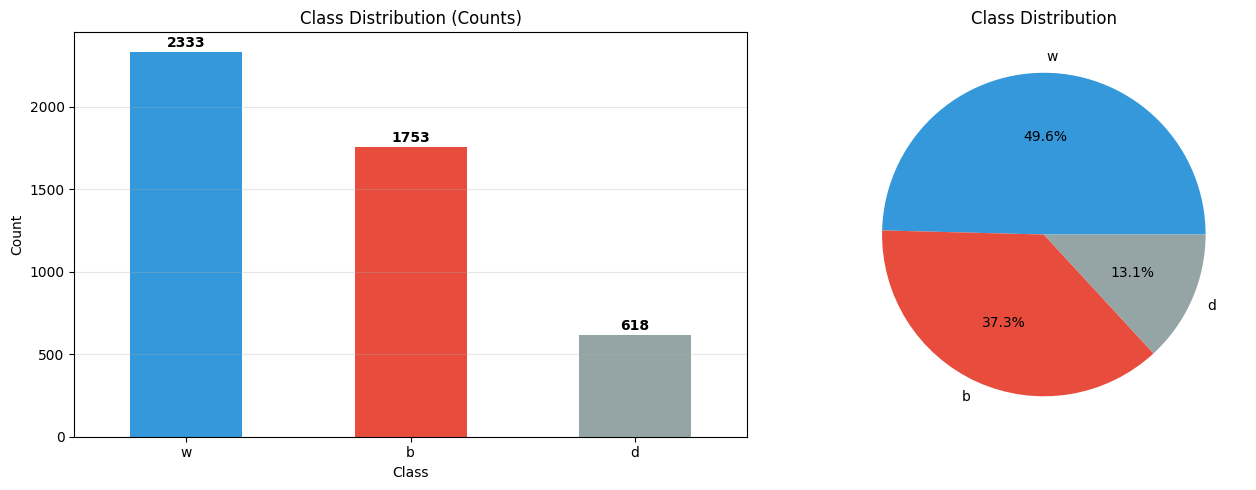

In [153]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
class_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Counts)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts):
    axes[0].text(i, v + 30, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Class Distribution')

plt.tight_layout()
plt.show()

##### yup thats imbalanced

In [154]:
# 3. Data Types and Categorical Features Check

dtype_summary = train_data.dtypes.value_counts()
print(f"\nData Types:")
print(dtype_summary)

# Identify object columns
object_cols = train_data.select_dtypes(include='object').columns.tolist()
print(f"Not Encoded Categorical Columns ({len(object_cols)}):")

for col in object_cols:
    unique_vals = train_data[col].unique()
    print(f"\n\t{col}:")
    print(f"\t\tUnique values: {len(unique_vals)}")
    print(f"\t\tValues: {sorted([str(x) for x in unique_vals if pd.notna(x)])}")


Data Types:
int64      35
object      6
float64     6
Name: count, dtype: int64
Not Encoded Categorical Columns (6):

	white_piece0_advanced:
		Unique values: 3
		Values: ['ATT', 'DEF', 'MID']

	black_piece0_advanced:
		Unique values: 3
		Values: ['ATT', 'DEF', 'MID']

	highest_strength:
		Unique values: 2
		Values: ['b', 'w']

	closest_to_den:
		Unique values: 2
		Values: ['b', 'w']

	fastest_to_den:
		Unique values: 2
		Values: ['b', 'w']

	class:
		Unique values: 3
		Values: ['b', 'd', 'w']


In [155]:
# 4. Numeric Features Distribution Check
# Select numeric columns
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nTotal numeric features: {len(numeric_cols)}")

# Check for sentinel values (-1)
sentinel_cols = []
for col in numeric_cols:
    if (train_data[col] == -1).any():
        sentinel_count = (train_data[col] == -1).sum()
        sentinel_cols.append((col, sentinel_count))


print(f"\nFeatures with -1 sentinel values ({len(sentinel_cols)}):")
for col, count in sentinel_cols:
    pct = (count / len(train_data)) * 100
    print(f"  {col}: {count} ({pct:.1f}%)")
print("\n-1 indicates 'blocked path' - this is intentional, not an outlier")



Total numeric features: 41

Features with -1 sentinel values (2):
  white_piece0_unopposedto_black_den_length: 2041 (43.4%)
  black_piece0_unopposedto_white_den_length: 2484 (52.8%)

-1 indicates 'blocked path' - this is intentional, not an outlier


In [156]:
# Categorize features by number of unique values
binary_features = []
multi_value_features = []

for col in numeric_cols:
    n_unique = jungle_dataset[col].nunique()
    if n_unique == 2:
        binary_features.append(col)
    elif n_unique > 2:
        multi_value_features.append(col)

print(f"\nBinary features: {len(binary_features)}")
print(f"Multi-value features: {len(multi_value_features)}")


Binary features: 21
Multi-value features: 18


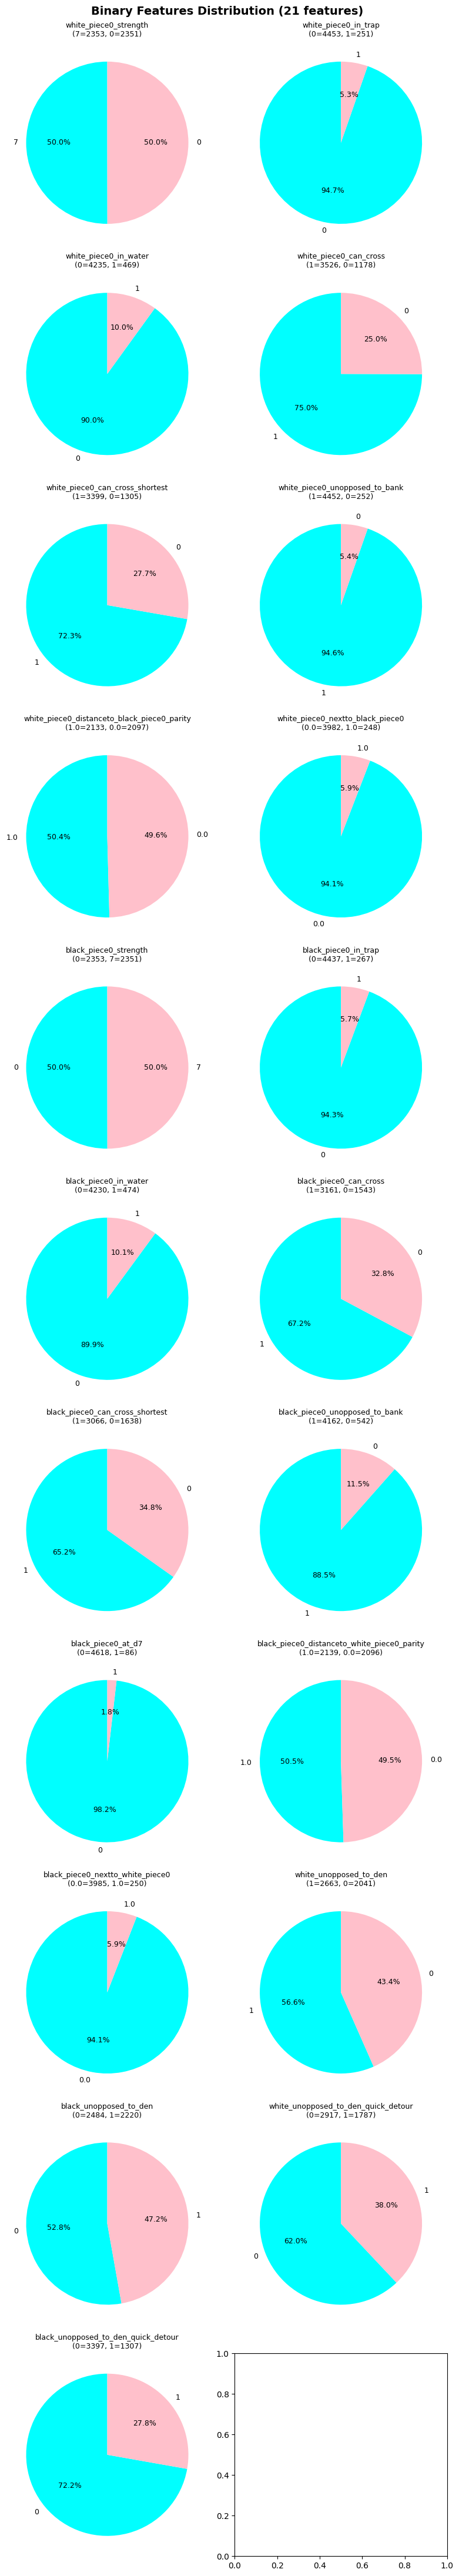

In [157]:
# Visualize Binary Features with Pie Charts
n_binary = len(binary_features)
n_cols = 2
n_rows = (n_binary + n_cols - 1) // n_cols
colors = ['cyan', 'pink']

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(binary_features):
    value_counts = train_data[col].value_counts()
    
    axes[idx].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', 
                    startangle=90, colors=colors, textprops={'fontsize': 9})
    axes[idx].set_title(f'{col}\n({value_counts.index[0]}={value_counts.iloc[0]}, '
                        f'{value_counts.index[1]}={value_counts.iloc[1]})', 
                        fontsize=9)


plt.suptitle(f'Binary Features Distribution ({len(binary_features)} features)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

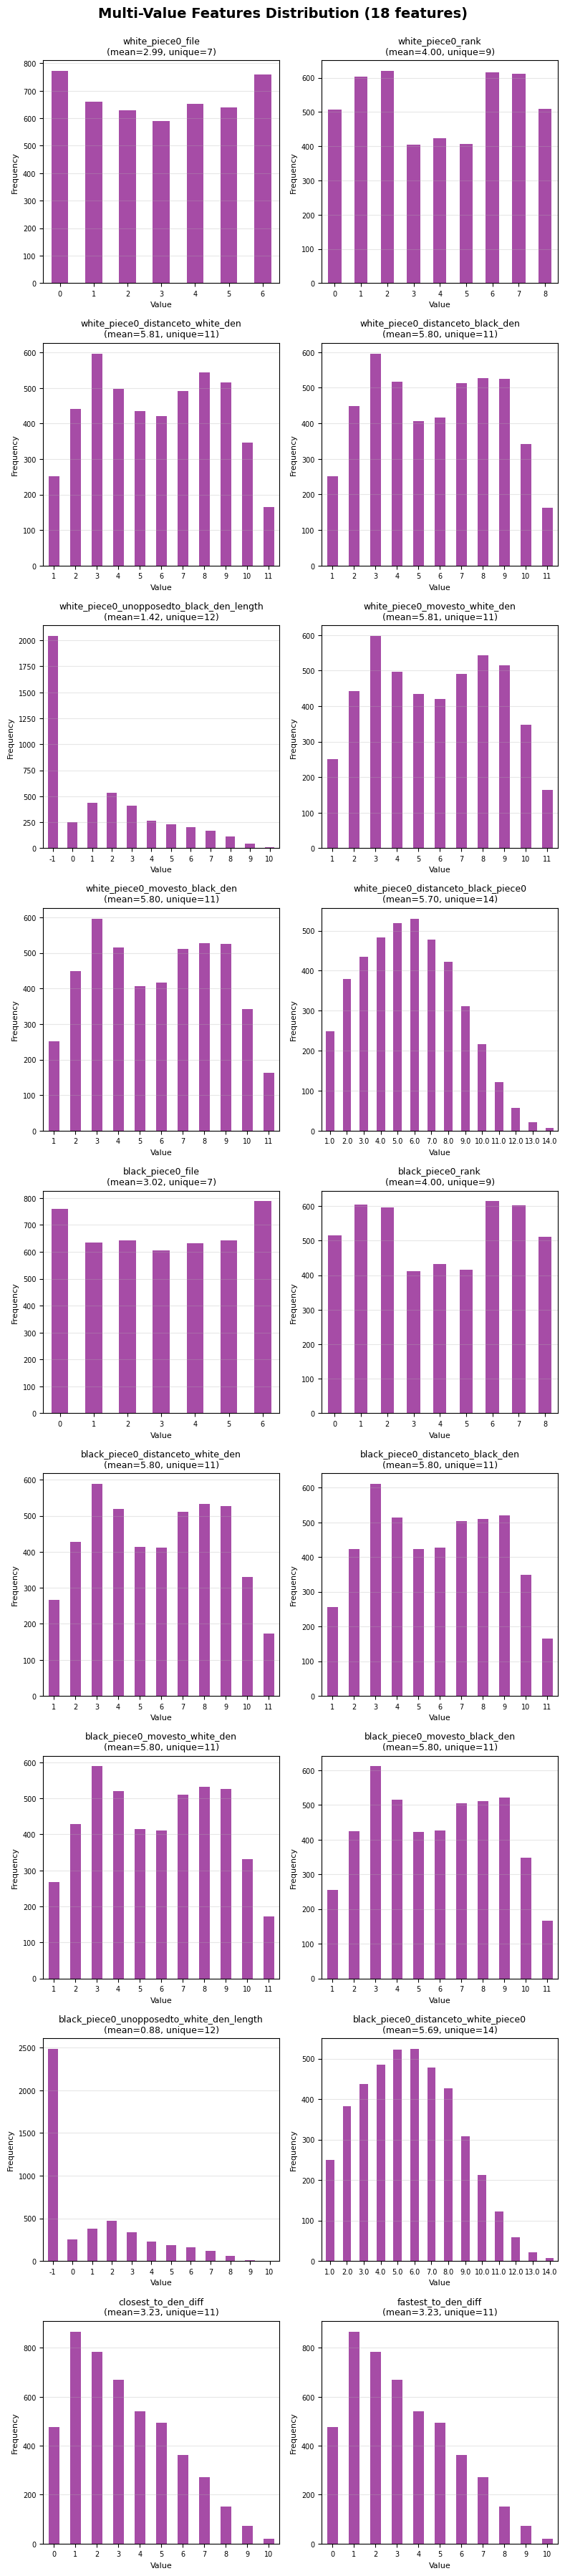

In [158]:
# Visualize Multi-Value Features with Bar Charts
n_multi = len(multi_value_features)
n_cols = 2
n_rows = (n_multi + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(multi_value_features):
    value_counts = train_data[col].value_counts().sort_index()
    
    value_counts.plot(kind='bar', ax=axes[idx], color='purple', alpha=0.7)
    axes[idx].set_title(f'{col}\n(mean={train_data[col].mean():.2f}, '
                        f'unique={train_data[col].nunique()})', 
                        fontsize=9)
    axes[idx].set_xlabel('Value', fontsize=8)
    axes[idx].set_ylabel('Frequency', fontsize=8)
    axes[idx].tick_params(axis='both', labelsize=7)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=0)

plt.suptitle(f'Multi-Value Features Distribution ({len(multi_value_features)} features)', 
            fontsize=14, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

In [159]:
# 5. Outliers Detection (using Z-Score method)

print("\nZ-Score Threshold: |z| > 3 (99.7% confidence interval)")
print("  - Values beyond +/-3 standard deviations are flagged as outliers\n")

# Calculate z-scores and detect outliers
outlier_summary = []

for col in multi_value_features:
    # Calculate z-scores
    mean = train_data[col].mean()
    std = train_data[col].std()
    
    if std == 0:
        continue
    
    z_scores = np.abs((train_data[col] - mean) / std)
    outliers = train_data[z_scores > 3]
    
    if len(outliers) > 0:
        outlier_summary.append({
            'Column': col,
            'Outliers_Count': len(outliers),
            'Outliers_Pct': (len(outliers) / len(train_data)) * 100,
            'Mean': mean,
            'Std': std,
            'Max_ZScore': z_scores.max()
        })

print(f"{len(outlier_summary)} have been flagged with outliers")


Z-Score Threshold: |z| > 3 (99.7% confidence interval)
  - Values beyond +/-3 standard deviations are flagged as outliers

2 have been flagged with outliers


Creating boxplots for 2 features with outliers...



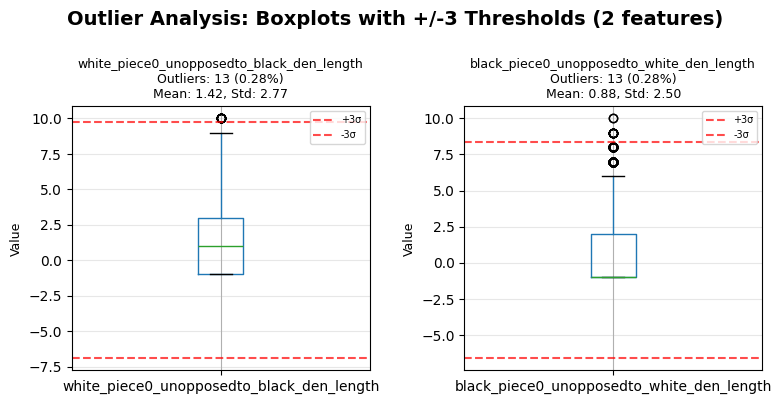

In [160]:
# Use Outlier Summary to analyze the outliers detected
outlier_cols = [item['Column'] for item in outlier_summary]

print(f"Creating boxplots for {len(outlier_cols)} features with outliers...\n")

n_cols_plot = 2
n_rows_plot = (len(outlier_cols) + n_cols_plot - 1) // n_cols_plot

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(8, 4 * n_rows_plot))


axes = axes.flatten()

for idx, col in enumerate(outlier_cols):
    # Get outlier info
    outlier_info = next(item for item in outlier_summary if item['Column'] == col)
    
    # Create boxplot
    train_data.boxplot(column=col, ax=axes[idx])
    
    # Add title with outlier stats
    axes[idx].set_title(
        f"{col}\n"
        f"Outliers: {outlier_info['Outliers_Count']} ({outlier_info['Outliers_Pct']:.2f}%)\n"
        f"Mean: {outlier_info['Mean']:.2f}, Std: {outlier_info['Std']:.2f}",
        fontsize=9
    )
    axes[idx].set_ylabel('Value', fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Highlight outlier threshold lines
    mean = outlier_info['Mean']
    std = outlier_info['Std']
    upper_threshold = mean + 3 * std
    lower_threshold = mean - 3 * std
    
    axes[idx].axhline(upper_threshold, color='red', linestyle='--', 
                        linewidth=1.5, alpha=0.7, label='+3σ')
    axes[idx].axhline(lower_threshold, color='red', linestyle='--', 
                        linewidth=1.5, alpha=0.7, label='-3σ')
    axes[idx].legend(fontsize=7, loc='upper right')


plt.suptitle(f'Outlier Analysis: Boxplots with +/-3 Thresholds ({len(outlier_cols)} features)', 
            fontsize=14, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

### The outliers here are not really outliers based on the domain
   - These are valid game positions, not measurement errors
   - Removing them would discard legitimate strategic tactical scenarios

---
## Light EDA Summary - Issues Identified
### Issues Found:
1. **Missing Values (\N)**: Present in distance/parity/nextto features
   - These are semantic nulls (piece interactions that don't exist)
   - Need domain-appropriate imputation

2. **Sentinel Values (-1)**: Indicates "blocked path" - this is intentional

3. **Categorical Features**: Need encoding before modeling

4. **Class Imbalance**: needed

5. **Outliers**: Game positions may have valid extreme values will not be handled


---
# Phase 2: Data Cleaning with Justified Decisions

Based on our Light EDA findings, we'll now clean the data systematically.
Every decision will be justified and visualized.


## Decision 1: Handling Missing Values (NaN)

### Analysis of Missing Data Pattern
Missing values appear in:
- `distanceto_black_piece0` / `distanceto_white_piece0`
- `distanceto_black_piece0_parity` / `distanceto_white_piece0_parity`
- `nextto_black_piece0` / `nextto_white_piece0`

### Why They're Missing
These NaNs are **semantic nulls** - they occur when:
- A piece doesn't exist on the board (captured)

### Imputation Strategy Decision

#### Why NOT Mean/Median:
- Mean/median would suggest "average distance" which is misleading
- Missing means "no interaction possible" not "some distance"
- Would create false tactical information

#### Why NOT Drop Rows:
- Would lose ~60% of data (3,528 NaN values)


In [161]:
# Create copies
train_data_clean = train_data.copy()
test_data_clean = test_data.copy()

print(f"Train missing values: {train_data_clean.isna().sum().sum()}")
print(f"Test missing values: {test_data_clean.isna().sum().sum()}")

# Identify columns by pattern
distance_cols = [col for col in train_data_clean.columns if 'distanceto' in col and 'parity' not in col]
parity_cols = [col for col in train_data_clean.columns if 'parity' in col]
nextto_cols = [col for col in train_data_clean.columns if 'nextto' in col]

print("\nImputation Strategy:")
print("\tDistance features -> Constant: -999 (piece doesn't exist)")
print("\tParity features -> Constant: -1 (undefined)")
print("\tNextto features -> Constant: 0 (not adjacent)")

# 1. Impute distance columns with -999
distance_imputer = SimpleImputer(strategy='constant', fill_value=-999)

# Fit on train and transform both
train_data_clean[distance_cols] = distance_imputer.fit_transform(train_data_clean[distance_cols])
test_data_clean[distance_cols] = distance_imputer.transform(test_data_clean[distance_cols])

# 2. Impute parity columns with -1
parity_imputer = SimpleImputer(strategy='constant', fill_value=-1)

train_data_clean[parity_cols] = parity_imputer.fit_transform(train_data_clean[parity_cols])
test_data_clean[parity_cols] = parity_imputer.transform(test_data_clean[parity_cols])


# 3. Impute nextto columns with 0
nextto_imputer = SimpleImputer(strategy='constant', fill_value=0)

train_data_clean[nextto_cols] = nextto_imputer.fit_transform(train_data_clean[nextto_cols])
test_data_clean[nextto_cols] = nextto_imputer.transform(test_data_clean[nextto_cols])

print(f"Train missing values: {train_data_clean.isna().sum().sum()}")
print(f"Test missing values: {test_data_clean.isna().sum().sum()}")

Train missing values: 2829
Test missing values: 699

Imputation Strategy:
	Distance features -> Constant: -999 (piece doesn't exist)
	Parity features -> Constant: -1 (undefined)
	Nextto features -> Constant: 0 (not adjacent)
Train missing values: 0
Test missing values: 0


In [162]:
jungle_dataset[['fastest_to_den', 'closest_to_den','highest_strength']].nunique()

,0
fastest_to_den,2
closest_to_den,2
highest_strength,2


## Categorical Feature Encoding


In [163]:
# Categorical encoding using LabelEncoder

categorical_cols = train_data_clean.select_dtypes(include=['object']).columns.tolist()

# Encode each categorical column
for col in categorical_cols:    
    le = LabelEncoder()
    
    # Fit on training and transform both data
    train_data_clean[col] = le.fit_transform(train_data_clean[col])
    test_data_clean[col] = le.transform(test_data_clean[col])
    
print("\nFinal dtypes:")
print(f"Train: {train_data_clean.dtypes.value_counts().to_dict()}")
print(f"Test: {test_data_clean.dtypes.value_counts().to_dict()}")


Final dtypes:
Train: {dtype('int64'): 37, dtype('float64'): 10}
Test: {dtype('int64'): 37, dtype('float64'): 10}


In [ ]:
train_data_clean
test_data_clean
# # # # # # # # # # # # # # # #

---
# Phase 3: Deep EDA - Understanding Patterns

Now that data is clean, we'll perform deep exploratory analysis on TRAINING data.


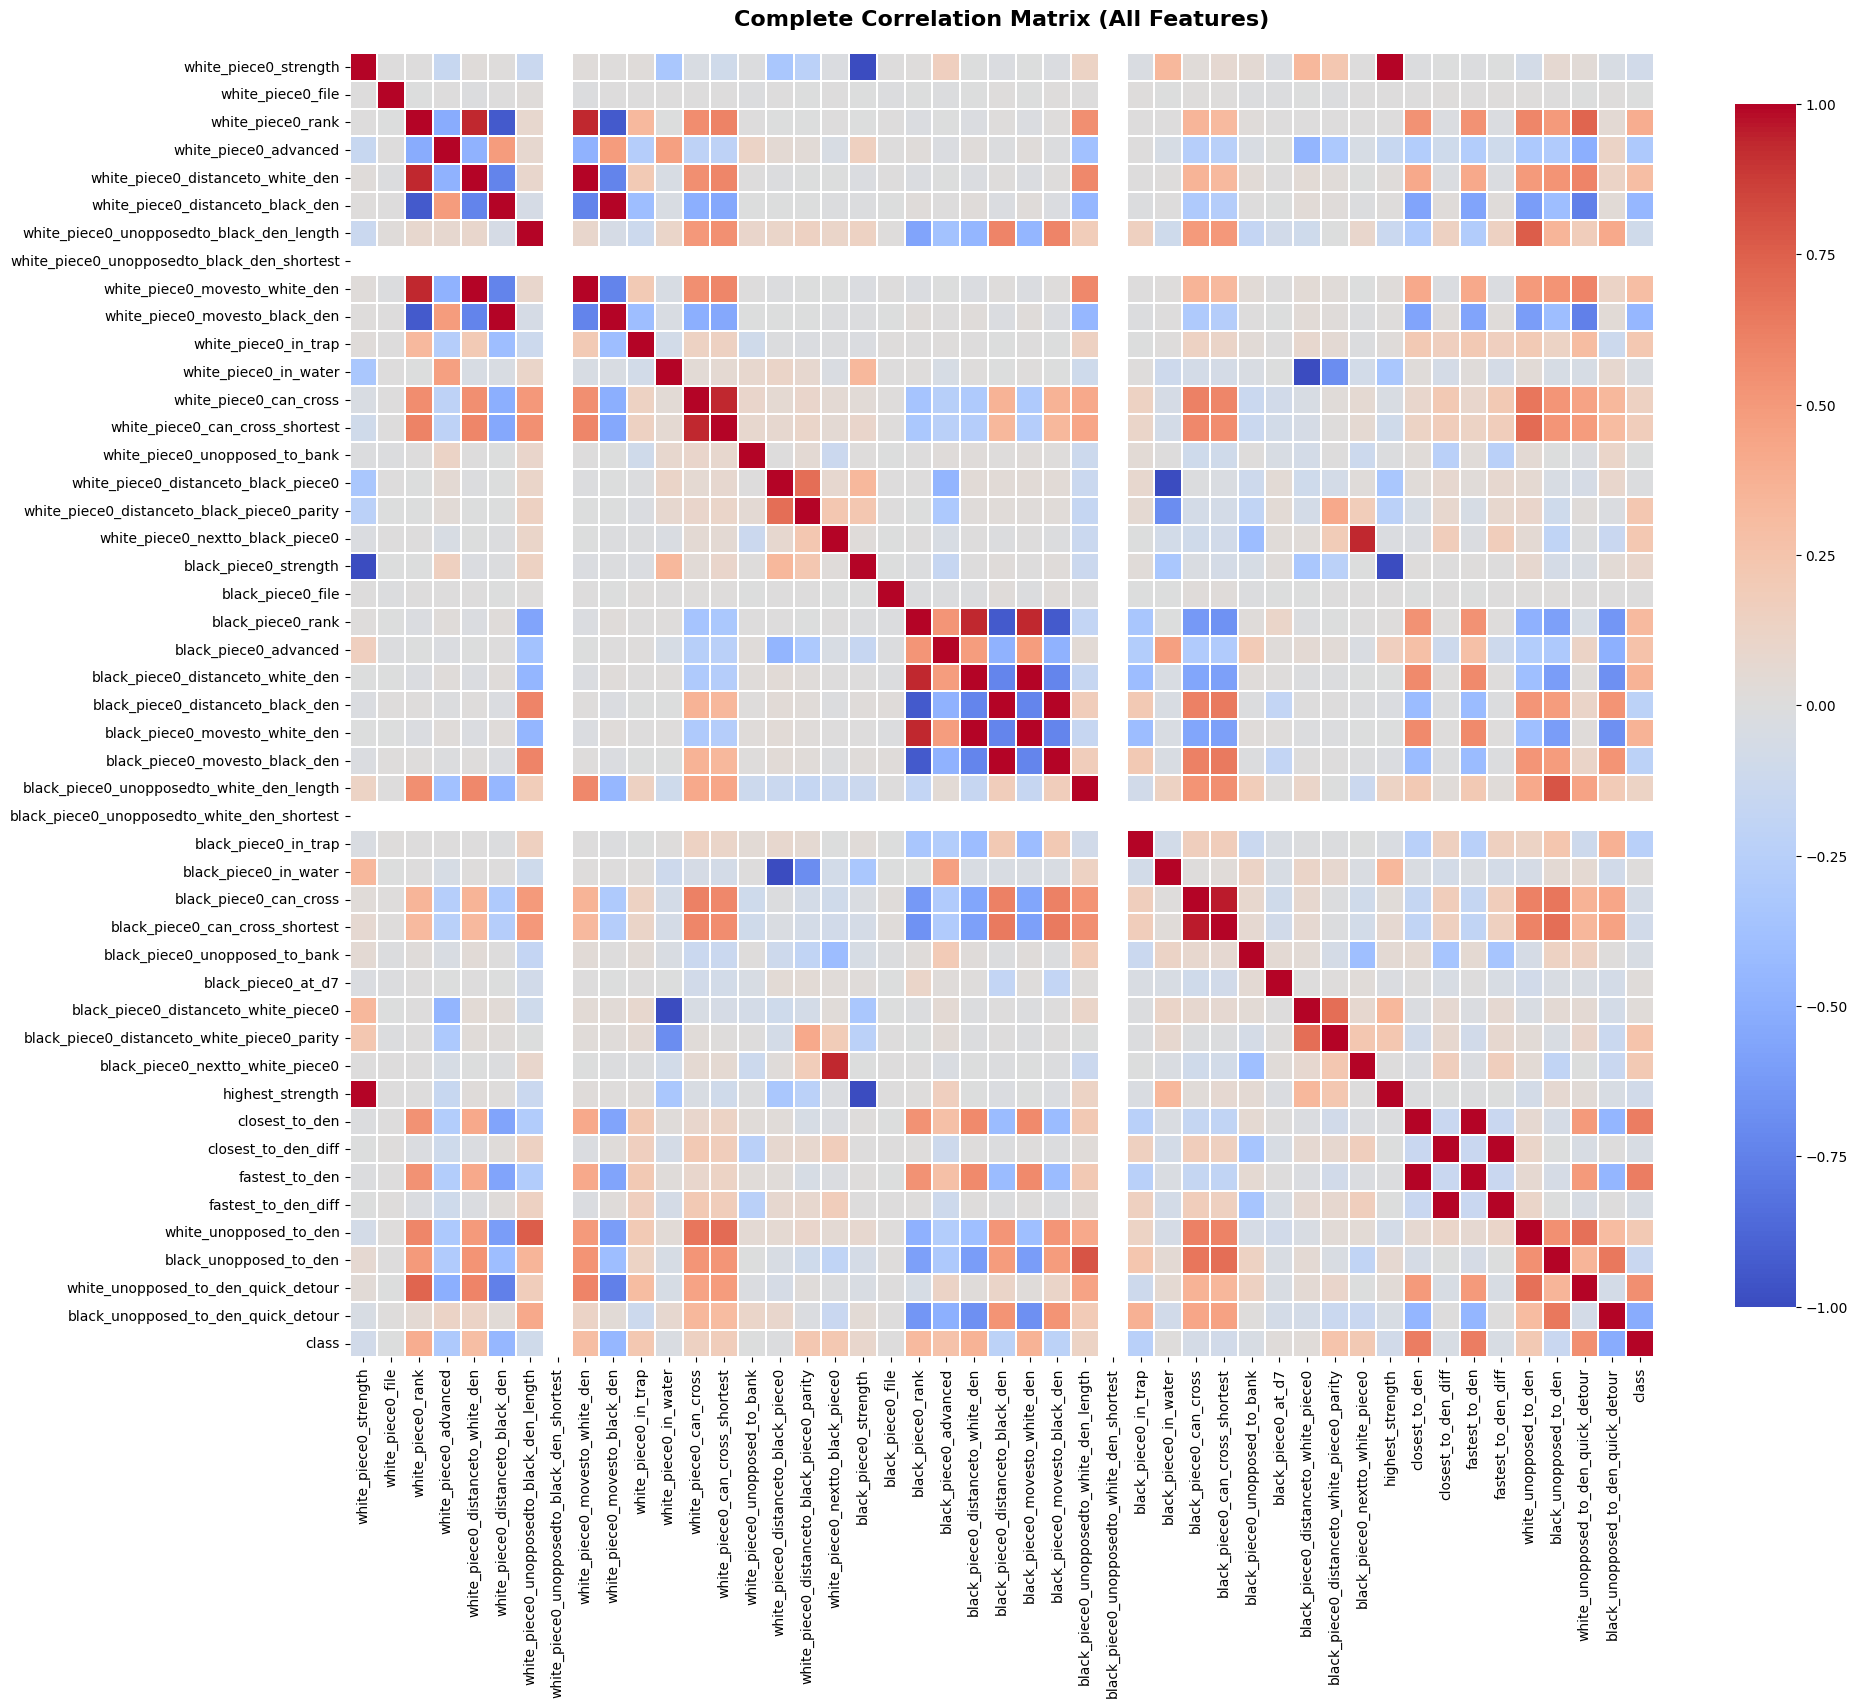

In [164]:
# Full Correlation Matrix

corr_matrix = train_data_clean.corr()

# Large heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Complete Correlation Matrix (All Features)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


Top 10 Positive Correlations:
fastest_to_den                         0.630958
closest_to_den                         0.630958
white_unopposed_to_den_quick_detour    0.551242
white_piece0_rank                      0.395719
black_piece0_movesto_white_den         0.365632
black_piece0_distanceto_white_den      0.365632
black_piece0_rank                      0.315088
white_piece0_distanceto_white_den      0.290263
white_piece0_movesto_white_den         0.290263
black_piece0_advanced                  0.262201
Name: class, dtype: float64

Top 10 Negative Correlations:
black_unopposed_to_den                        -0.145998
black_piece0_distanceto_black_den             -0.220918
black_piece0_movesto_black_den                -0.220918
black_piece0_in_trap                          -0.244576
white_piece0_advanced                         -0.309420
white_piece0_distanceto_black_den             -0.447253
white_piece0_movesto_black_den                -0.447253
black_unopposed_to_den_quick_detour   

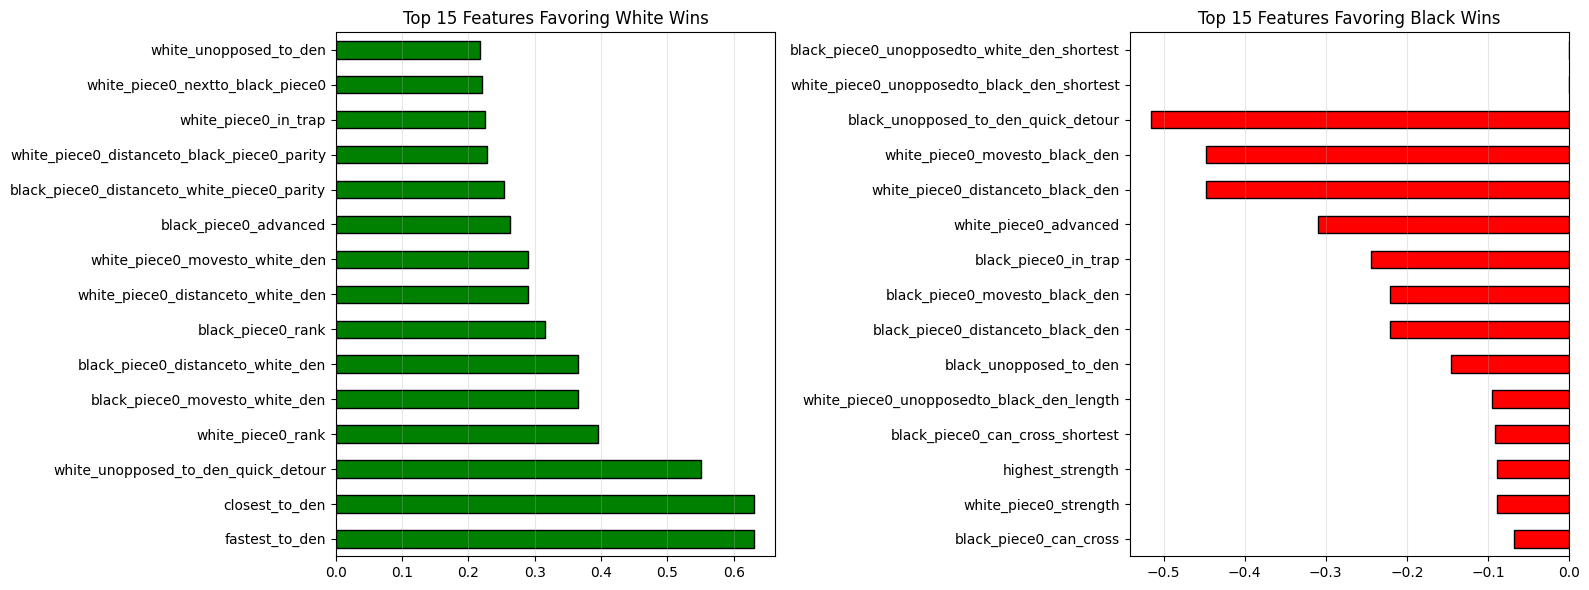

In [165]:
# Feature Correlation with Target

target_corr = train_data_clean.corr()['class'].drop('class').sort_values(ascending=False)

print("\nTop 10 Positive Correlations:")
print(target_corr.head(10))

print("\nTop 10 Negative Correlations:")
print(target_corr.tail(10))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

target_corr.head(15).plot(kind='barh', ax=axes[0], color='green', edgecolor='black')
axes[0].set_title('Top 15 Features Favoring White Wins')
axes[0].grid(axis='x', alpha=0.3)

target_corr.tail(15).plot(kind='barh', ax=axes[1], color='red', edgecolor='black')
axes[1].set_title('Top 15 Features Favoring Black Wins')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Features: ['fastest_to_den', 'closest_to_den', 'white_unopposed_to_den_quick_detour', 'black_unopposed_to_den_quick_detour']



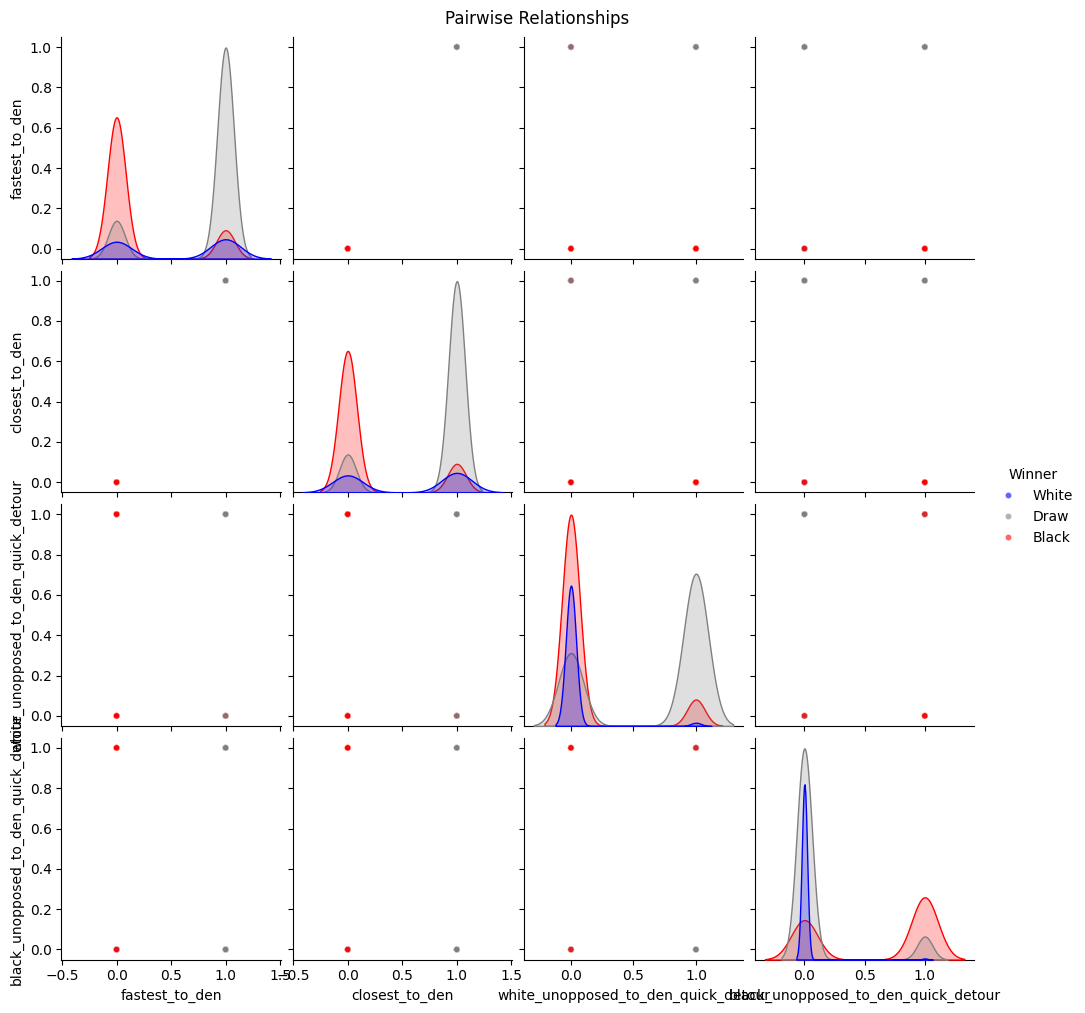

In [166]:
# Pairplot of top correlated features

top4 = target_corr.abs().nlargest(4).index.tolist()
pairplot_data = train_data_clean[top4 + ['class']].copy()
pairplot_data['Winner'] = pairplot_data['class'].map({0: 'Black', 1: 'White', 2: 'Draw'})
pairplot_data = pairplot_data.drop('class', axis=1)

print(f"Features: {top4}\n")

sns.pairplot(pairplot_data, hue='Winner', palette={'Black': 'red', 'White': 'blue', 'Draw': 'gray'},
             plot_kws={'alpha': 0.6, 's': 20}, diag_kind='kde')
plt.suptitle('Pairwise Relationships', y=1.01)
plt.show()

In [ ]:
train_data_clean
test_data_clean
# # # # # # # # # # # # # # # #

---
# Phase 4: Comprehensive Modeling Pipeline

## Workflow:
1. **Feature Selection** - Select best features using correlation and importance
2. **Imbalance Handling** - 4 strategies (None, SVMSMOTE, TomekLinks, SMOTETomek)
3. **Model Training** - 7 classifiers (DT, LR, SVM, KNN, RF, GB, XGB)
4. **Ensemble Methods** - VotingClassifier, StackingClassifier, BaggingClassifier
5. **Hyperparameter Tuning** - StratifiedKFold cross-validation
6. **Evaluation** - Metrics, Learning Curves, Bias-Variance Analysis
7. **MLflow Logging** - Track everything


In [ ]:
# MLflow Setup
mlflow.set_experiment("Jungle_Chess_Classification")
print("✅ MLflow experiment set!")

# MLflow logging functions
def log_metrics_to_mlflow(y_true, y_pred, y_proba=None, prefix=''):
    """Log classification metrics to MLflow"""
    metrics = {
        f'{prefix}accuracy': accuracy_score(y_true, y_pred),
        f'{prefix}precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        f'{prefix}mcc': matthews_corrcoef(y_true, y_pred),
        f'{prefix}cohen_kappa': cohen_kappa_score(y_true, y_pred)
    }
    if y_proba is not None:
        try:
            metrics[f'{prefix}roc_auc'] = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
        except:
            pass
    mlflow.log_metrics(metrics)
    return metrics

def log_confusion_matrix_plot(y_true, y_pred, title='Confusion Matrix'):
    """Log confusion matrix as artifact"""
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Black', 'White', 'Draw'], yticklabels=['Black', 'White', 'Draw'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.tight_layout()
    filename = 'confusion_matrix.png'
    plt.savefig(filename, dpi=100)
    mlflow.log_artifact(filename)
    plt.show()
    plt.close()

print("✅ MLflow logging functions defined!")

In [ ]:
# Prepare X and y from cleaned data
X_train = train_data_clean.drop('class', axis=1)
y_train = train_data_clean['class']

X_test = test_data_clean.drop('class', axis=1)
y_test = test_data_clean['class']

print("="*60)
print("DATA PREPARED FOR MODELING")
print("="*60)
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nClass distribution in y_train:")
print(y_train.value_counts().sort_index())
print(f"\nFeature names: {X_train.columns.tolist()}")

## Step 1: Feature Selection

Using multiple methods:
1. Correlation with target
2. Random Forest feature importance
3. Select top features


In [ ]:
# Feature Selection
print("="*60)
print("FEATURE SELECTION")
print("="*60)

# Method 1: Correlation with target
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("\n1. Top 15 features by correlation with target:")
print(correlations.head(15))

# Method 2: Random Forest importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
rf_selector.fit(X_train, y_train)
importances = pd.Series(rf_selector.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\n2. Top 15 features by Random Forest importance:")
print(importances.head(15))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

correlations.head(15).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 15 Features by Correlation')
axes[0].set_xlabel('Absolute Correlation')

importances.head(15).plot(kind='barh', ax=axes[1], color='forestgreen')
axes[1].set_title('Top 15 Features by RF Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Select top features (union of top 20 from each method)
top_corr_features = set(correlations.head(20).index)
top_rf_features = set(importances.head(20).index)
selected_features = list(top_corr_features.union(top_rf_features))

print(f"\n3. Selected {len(selected_features)} features (union of top 20 from each method)")
print(f"Selected features: {selected_features}")

# Create selected feature datasets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\nX_train_selected shape: {X_train_selected.shape}")
print(f"X_test_selected shape: {X_test_selected.shape}")

## Step 2: Imbalance Handling Strategies

We'll create 4 different datasets:
1. **No Resampling** - Baseline
2. **SVMSMOTE** - Oversampling (SVM-based SMOTE)
3. **TomekLinks** - Undersampling (removes borderline samples)
4. **SMOTETomek** - Combined (SMOTE + TomekLinks)


In [ ]:
# Imbalance Handling
print("="*60)
print("IMBALANCE HANDLING")
print("="*60)

# Convert to numpy for resampling
X_np = X_train_selected.values
y_np = y_train.values

# Store resampled datasets
resampled_data = {}

# 1. No Resampling (Baseline)
resampled_data['None'] = (X_np.copy(), y_np.copy())
print(f"\n1. No Resampling: {X_np.shape[0]} samples")

# 2. SVMSMOTE (Oversampling)
try:
    svmsmote = SVMSMOTE(random_state=RANDOM_SEED, k_neighbors=3)
    X_svm, y_svm = svmsmote.fit_resample(X_np, y_np)
    resampled_data['SVMSMOTE'] = (X_svm, y_svm)
    print(f"2. SVMSMOTE: {X_svm.shape[0]} samples (oversampled)")
except Exception as e:
    print(f"2. SVMSMOTE failed: {e}")
    resampled_data['SVMSMOTE'] = (X_np.copy(), y_np.copy())

# 3. TomekLinks (Undersampling)
try:
    tomek = TomekLinks()
    X_tomek, y_tomek = tomek.fit_resample(X_np, y_np)
    resampled_data['TomekLinks'] = (X_tomek, y_tomek)
    print(f"3. TomekLinks: {X_tomek.shape[0]} samples (undersampled)")
except Exception as e:
    print(f"3. TomekLinks failed: {e}")
    resampled_data['TomekLinks'] = (X_np.copy(), y_np.copy())

# 4. SMOTETomek (Combined)
try:
    smotetomek = SMOTETomek(random_state=RANDOM_SEED)
    X_st, y_st = smotetomek.fit_resample(X_np, y_np)
    resampled_data['SMOTETomek'] = (X_st, y_st)
    print(f"4. SMOTETomek: {X_st.shape[0]} samples (combined)")
except Exception as e:
    print(f"4. SMOTETomek failed: {e}")
    resampled_data['SMOTETomek'] = (X_np.copy(), y_np.copy())

# Visualize class distribution after resampling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, (X_res, y_res)) in enumerate(resampled_data.items()):
    unique, counts = np.unique(y_res, return_counts=True)
    axes[idx].bar(unique, counts, color=['#e74c3c', '#3498db', '#95a5a6'])
    axes[idx].set_title(f'{name}\n(Total: {len(y_res)} samples)')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks([0, 1, 2])
    axes[idx].set_xticklabels(['Black', 'White', 'Draw'])
    for i, (u, c) in enumerate(zip(unique, counts)):
        axes[idx].text(u, c + 20, str(c), ha='center', fontweight='bold')

plt.suptitle('Class Distribution After Resampling', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ All resampling strategies applied!")

## Step 3: Define Base Models

7 classification models:
1. Decision Tree
2. Logistic Regression
3. SVM
4. KNN
5. Random Forest
6. Gradient Boosting
7. XGBoost


In [ ]:
# Define Base Models
print("="*60)
print("DEFINE BASE MODELS")
print("="*60)

base_models = {
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'LogisticRegression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    'SVM': SVC(random_state=RANDOM_SEED, probability=True),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_SEED),
    'XGBoost': XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss', use_label_encoder=False)
}

print("\nBase models defined:")
for name in base_models.keys():
    print(f"  - {name}")

print(f"\nTotal: {len(base_models)} models")

## Step 4: Train Base Models on All Resampled Datasets

Train each model on each resampling strategy and log to MLflow.


In [ ]:
# Train Base Models
print("="*60)
print("TRAINING BASE MODELS")
print("="*60)

# Store results
results = []
trained_models = {}

# Prepare test data
X_test_np = X_test_selected.values
y_test_np = y_test.values

# Scale features for models that need it
scaler = StandardScaler()

for resample_name, (X_res, y_res) in resampled_data.items():
    print(f"\n{'='*40}")
    print(f"Resampling: {resample_name}")
    print(f"{'='*40}")
    
    # Scale data
    X_train_scaled = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test_np)
    
    for model_name, model in base_models.items():
        # Clone model for fresh training
        model_clone = model.__class__(**model.get_params())
        
        run_name = f"{model_name}_{resample_name}"
        
        with mlflow.start_run(run_name=run_name):
            # Log params
            mlflow.log_param('model', model_name)
            mlflow.log_param('resampling', resample_name)
            mlflow.log_param('n_features', X_res.shape[1])
            mlflow.log_param('n_train_samples', X_res.shape[0])
            
            # Use scaled data for SVM, LR, KNN
            if model_name in ['SVM', 'LogisticRegression', 'KNN']:
                X_train_use = X_train_scaled
                X_test_use = X_test_scaled
            else:
                X_train_use = X_res
                X_test_use = X_test_np
            
            # Train
            model_clone.fit(X_train_use, y_res)
            
            # Predict
            y_pred = model_clone.predict(X_test_use)
            y_proba = model_clone.predict_proba(X_test_use) if hasattr(model_clone, 'predict_proba') else None
            
            # Calculate metrics
            acc = accuracy_score(y_test_np, y_pred)
            f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
            prec = precision_score(y_test_np, y_pred, average='macro', zero_division=0)
            rec = recall_score(y_test_np, y_pred, average='macro', zero_division=0)
            
            # Log metrics
            log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
            
            # Store results
            results.append({
                'Model': model_name,
                'Resampling': resample_name,
                'Accuracy': acc,
                'F1_Macro': f1,
                'Precision': prec,
                'Recall': rec
            })
            
            # Store trained model
            trained_models[run_name] = model_clone
            
            print(f"  {model_name}: Acc={acc:.4f}, F1={f1:.4f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("✅ All base models trained!")
print(f"Total runs: {len(results)}")

In [ ]:
# Results Summary
print("="*60)
print("BASE MODEL RESULTS SUMMARY")
print("="*60)

# Pivot table for better visualization
pivot_acc = results_df.pivot(index='Model', columns='Resampling', values='Accuracy')
pivot_f1 = results_df.pivot(index='Model', columns='Resampling', values='F1_Macro')

print("\nAccuracy by Model and Resampling:")
print(pivot_acc.round(4).to_string())

print("\nF1 Macro by Model and Resampling:")
print(pivot_f1.round(4).to_string())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pivot_acc.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Accuracy by Model and Resampling', fontweight='bold')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].legend(title='Resampling')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

pivot_f1.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('F1 Macro by Model and Resampling', fontweight='bold')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Macro')
axes[1].legend(title='Resampling')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Best model per resampling
print("\nBest Model per Resampling Strategy (by F1):")
for resample in resampled_data.keys():
    best_row = results_df[results_df['Resampling'] == resample].nlargest(1, 'F1_Macro').iloc[0]
    print(f"  {resample}: {best_row['Model']} (F1={best_row['F1_Macro']:.4f})")

## Step 5: Ensemble Methods

Create ensembles for each resampling strategy:
1. **VotingClassifier** - Soft voting of top 3 models
2. **StackingClassifier** - Stack with LogisticRegression meta-learner
3. **BaggingClassifier** - Bagging with best base model


In [ ]:
# Ensemble Methods
print("="*60)
print("ENSEMBLE METHODS")
print("="*60)

ensemble_results = []

for resample_name, (X_res, y_res) in resampled_data.items():
    print(f"\n{'='*40}")
    print(f"Ensembles for: {resample_name}")
    print(f"{'='*40}")
    
    # Scale data
    X_train_scaled = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test_np)
    
    # 1. VotingClassifier (soft voting)
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
            ('xgb', XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss', use_label_encoder=False)),
            ('gb', GradientBoostingClassifier(random_state=RANDOM_SEED))
        ],
        voting='soft'
    )
    
    with mlflow.start_run(run_name=f'VotingClassifier_{resample_name}'):
        mlflow.log_param('ensemble', 'VotingClassifier')
        mlflow.log_param('resampling', resample_name)
        mlflow.log_param('voting', 'soft')
        
        voting_clf.fit(X_res, y_res)
        y_pred = voting_clf.predict(X_test_np)
        y_proba = voting_clf.predict_proba(X_test_np)
        
        acc = accuracy_score(y_test_np, y_pred)
        f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
        log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
        
        ensemble_results.append({'Ensemble': 'VotingClassifier', 'Resampling': resample_name, 
                                 'Accuracy': acc, 'F1_Macro': f1})
        print(f"  VotingClassifier: Acc={acc:.4f}, F1={f1:.4f}")
    
    # 2. StackingClassifier
    stacking_clf = StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=50)),
            ('dt', DecisionTreeClassifier(random_state=RANDOM_SEED)),
            ('knn', KNeighborsClassifier())
        ],
        final_estimator=LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
        cv=3
    )
    
    with mlflow.start_run(run_name=f'StackingClassifier_{resample_name}'):
        mlflow.log_param('ensemble', 'StackingClassifier')
        mlflow.log_param('resampling', resample_name)
        mlflow.log_param('meta_learner', 'LogisticRegression')
        
        stacking_clf.fit(X_train_scaled, y_res)
        y_pred = stacking_clf.predict(X_test_scaled)
        y_proba = stacking_clf.predict_proba(X_test_scaled)
        
        acc = accuracy_score(y_test_np, y_pred)
        f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
        log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
        
        ensemble_results.append({'Ensemble': 'StackingClassifier', 'Resampling': resample_name,
                                 'Accuracy': acc, 'F1_Macro': f1})
        print(f"  StackingClassifier: Acc={acc:.4f}, F1={f1:.4f}")
    
    # 3. BaggingClassifier
    bagging_clf = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_SEED),
        n_estimators=50,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    
    with mlflow.start_run(run_name=f'BaggingClassifier_{resample_name}'):
        mlflow.log_param('ensemble', 'BaggingClassifier')
        mlflow.log_param('resampling', resample_name)
        mlflow.log_param('base_estimator', 'DecisionTree')
        mlflow.log_param('n_estimators', 50)
        
        bagging_clf.fit(X_res, y_res)
        y_pred = bagging_clf.predict(X_test_np)
        y_proba = bagging_clf.predict_proba(X_test_np)
        
        acc = accuracy_score(y_test_np, y_pred)
        f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
        log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
        
        ensemble_results.append({'Ensemble': 'BaggingClassifier', 'Resampling': resample_name,
                                 'Accuracy': acc, 'F1_Macro': f1})
        print(f"  BaggingClassifier: Acc={acc:.4f}, F1={f1:.4f}")

ensemble_df = pd.DataFrame(ensemble_results)
print("\n✅ All ensemble methods trained!")

In [ ]:
# Ensemble Results Summary
print("="*60)
print("ENSEMBLE RESULTS SUMMARY")
print("="*60)

pivot_ens = ensemble_df.pivot(index='Ensemble', columns='Resampling', values='F1_Macro')
print("\nF1 Macro by Ensemble and Resampling:")
print(pivot_ens.round(4).to_string())

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
pivot_ens.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Ensemble F1 Macro by Resampling Strategy', fontweight='bold')
ax.set_xlabel('Ensemble Method')
ax.set_ylabel('F1 Macro')
ax.legend(title='Resampling')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Best overall
best_ens = ensemble_df.nlargest(3, 'F1_Macro')
print("\nTop 3 Ensemble Configurations:")
print(best_ens.to_string(index=False))

## Step 6: Hyperparameter Tuning with StratifiedKFold

Tune the best performing models using RandomizedSearchCV with StratifiedKFold.


In [ ]:
# Hyperparameter Tuning
print("="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# Use best resampling strategy (SMOTETomek typically performs well)
X_tuning, y_tuning = resampled_data['SMOTETomek']

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Parameter grids
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_samples_split': [2, 5]
    }
}

tuned_models = {}
tuning_results = []

for model_name in ['RandomForest', 'XGBoost', 'GradientBoosting']:
    print(f"\nTuning {model_name}...")
    
    model = base_models[model_name].__class__(**base_models[model_name].get_params())
    
    search = RandomizedSearchCV(
        model,
        param_grids[model_name],
        n_iter=20,
        cv=skf,
        scoring='f1_macro',
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    
    with mlflow.start_run(run_name=f'{model_name}_Tuned'):
        search.fit(X_tuning, y_tuning)
        
        # Log best params
        mlflow.log_params(search.best_params_)
        mlflow.log_param('model', model_name)
        mlflow.log_param('tuning', 'RandomizedSearchCV')
        mlflow.log_metric('cv_best_f1', search.best_score_)
        
        # Evaluate on test
        y_pred = search.best_estimator_.predict(X_test_np)
        y_proba = search.best_estimator_.predict_proba(X_test_np)
        
        acc = accuracy_score(y_test_np, y_pred)
        f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
        log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
        
        tuned_models[model_name] = search.best_estimator_
        tuning_results.append({
            'Model': model_name,
            'CV_F1': search.best_score_,
            'Test_Accuracy': acc,
            'Test_F1': f1,
            'Best_Params': search.best_params_
        })
        
        print(f"  Best CV F1: {search.best_score_:.4f}")
        print(f"  Test F1: {f1:.4f}")
        print(f"  Best Params: {search.best_params_}")

tuning_df = pd.DataFrame(tuning_results)
print("\n✅ Hyperparameter tuning complete!")

## Step 7: Learning Curves & Bias-Variance Analysis

Visualize how models perform with different training sizes.


In [ ]:
# Learning Curves
print("="*60)
print("LEARNING CURVES")
print("="*60)

from sklearn.model_selection import learning_curve

# Use best tuned models
models_to_plot = {
    'RandomForest': tuned_models.get('RandomForest', RandomForestClassifier(random_state=RANDOM_SEED)),
    'XGBoost': tuned_models.get('XGBoost', XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss', use_label_encoder=False)),
    'GradientBoosting': tuned_models.get('GradientBoosting', GradientBoostingClassifier(random_state=RANDOM_SEED))
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model) in enumerate(models_to_plot.items()):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_tuning, y_tuning,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    axes[idx].plot(train_sizes, train_mean, 'o-', label='Training', color='blue')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    axes[idx].plot(train_sizes, val_mean, 'o-', label='Validation', color='orange')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
    
    axes[idx].set_title(f'{name}\nLearning Curve', fontweight='bold')
    axes[idx].set_xlabel('Training Size')
    axes[idx].set_ylabel('F1 Macro')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    
    # Bias-Variance analysis
    gap = train_mean[-1] - val_mean[-1]
    if gap > 0.1:
        diagnosis = 'High Variance (Overfitting)'
    elif val_mean[-1] < 0.7:
        diagnosis = 'High Bias (Underfitting)'
    else:
        diagnosis = 'Good Fit'
    axes[idx].text(0.5, 0.02, f'Gap: {gap:.3f} - {diagnosis}', 
                   transform=axes[idx].transAxes, fontsize=9, ha='center')

plt.suptitle('Learning Curves - Bias/Variance Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=100)
mlflow.log_artifact('learning_curves.png')
plt.show()

print("\n✅ Learning curves generated!")

## Step 8: Final Model Evaluation

Select the best model and do comprehensive evaluation.


In [ ]:
# Final Model Evaluation
print("="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

# Find best model from tuning
best_model_name = tuning_df.loc[tuning_df['Test_F1'].idxmax(), 'Model']
best_model = tuned_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best Params: {tuning_df.loc[tuning_df['Test_F1'].idxmax(), 'Best_Params']}")

# Final predictions
y_pred_final = best_model.predict(X_test_np)
y_proba_final = best_model.predict_proba(X_test_np)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_final, target_names=['Black', 'White', 'Draw']))

# Confusion Matrix
log_confusion_matrix_plot(y_test_np, y_pred_final, title=f'Best Model: {best_model_name}')

# Log final model to MLflow
with mlflow.start_run(run_name=f'BEST_{best_model_name}'):
    mlflow.log_param('model', best_model_name)
    mlflow.log_param('type', 'BEST_MODEL')
    log_metrics_to_mlflow(y_test_np, y_pred_final, y_proba_final, prefix='final_')
    mlflow.sklearn.log_model(best_model, 'best_model')
    
print("\n✅ Best model logged to MLflow!")

In [ ]:
# All Results Summary
print("="*60)
print("COMPLETE RESULTS SUMMARY")
print("="*60)

# Combine all results
all_results = pd.concat([
    results_df.assign(Type='Base Model'),
    ensemble_df.rename(columns={'Ensemble': 'Model'}).assign(Type='Ensemble'),
    tuning_df[['Model', 'Test_F1']].rename(columns={'Test_F1': 'F1_Macro'}).assign(Type='Tuned', Resampling='SMOTETomek')
], ignore_index=True)

# Top 10 overall
print("\nTop 10 Models Overall (by F1 Macro):")
top10 = all_results.nlargest(10, 'F1_Macro')[['Model', 'Resampling', 'Type', 'F1_Macro']]
print(top10.to_string(index=False))

# Visualize top 10
fig, ax = plt.subplots(figsize=(12, 6))
colors = {'Base Model': 'steelblue', 'Ensemble': 'forestgreen', 'Tuned': 'coral'}
bars = ax.barh(range(len(top10)), top10['F1_Macro'], 
               color=[colors[t] for t in top10['Type']])
ax.set_yticks(range(len(top10)))
ax.set_yticklabels([f"{row['Model']} ({row['Resampling']})" for _, row in top10.iterrows()])
ax.set_xlabel('F1 Macro')
ax.set_title('Top 10 Models by F1 Macro Score', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=t) for t, c in colors.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('top10_models.png', dpi=100)
mlflow.log_artifact('top10_models.png')
plt.show()

print("\n" + "="*60)
print("🎉 MODELING PIPELINE COMPLETE!")
print("="*60)
print(f"\nTotal MLflow runs: Check mlflow ui for details")
print(f"Best model: {best_model_name}")
print(f"Best F1: {tuning_df['Test_F1'].max():.4f}")